<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/knn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=8f361077-78dd-4704-97ea-7361e344494b
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:01<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 42.2MB/s]


Training Data Shape: (60000, 784)
Testing Data Shape: (10000, 784)


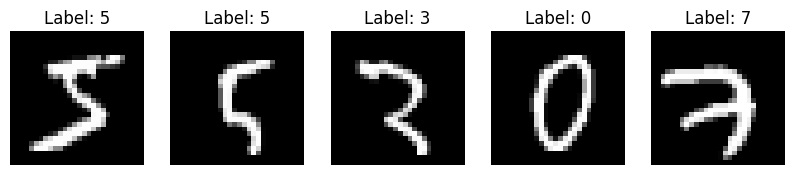

In [6]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

# Download dataset
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"

train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)

# Load Data
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)

# Extract Features & Labels
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize Features

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values / 255.0

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Display Fixed Sample Images
fixed_indices = [0, 100, 500, 1000, 5000]  # Fixed indices for consistent display
fig, axes = plt.subplots(1, len(fixed_indices), figsize=(10, 3))
for i, ax in enumerate(axes):
    index = fixed_indices[i]
    ax.imshow(X_train[index].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[index]}")
    ax.axis("off")
plt.show()


Euclidean Distance Formula
The Euclidean distance between two points
𝑥
1
x
1
​
  and
𝑥
2
x
2
​
  in an
𝑛
n-dimensional space is given by:

𝑑
(
𝑥
1
,
𝑥
2
)
=
∑
𝑖
=
1
𝑛
(
𝑥
1
𝑖
−
𝑥
2
𝑖
)
2
d(x
1
​
 ,x
2
​
 )=
i=1
∑
n
​
 (x
1i
​
 −x
2i
​
 )
2

​


**KNN Classifier**

Training (fit method) :
Stores the training data (X_train, y_train) for future reference.

No actual "learning" happens (lazy learning).

Prediction (predict method) :
Computes the Euclidean distance between a test point and all training points.
Finds the k closest neighbors and assigns the most frequent label (majority voting).

Probability Estimation (predict_proba method) :
Calculates the probability of each class based on the proportion of k neighbors belonging to that class.

In [7]:
# Euclidean Distance Function
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# KNN Classifier (Manual)
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in tqdm(X_test, desc="Predicting")]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[: self.k]
        k_labels = [self.y_train[i] for i in k_indices]

        # Manual Majority Voting
        label_count = {}
        for label in k_labels:
            label_count[label] = label_count.get(label, 0) + 1
        return max(label_count, key=label_count.get)

    def predict_proba(self, X_test):
        probabilities = [self._predict_proba(x) for x in tqdm(X_test, desc="Predicting Probabilities")]
        return np.array(probabilities)

    def _predict_proba(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[: self.k]
        k_labels = [self.y_train[i] for i in k_indices]

        probs = np.zeros(10)  # Assuming 10 classes (0-9)
        for label in k_labels:
            probs[label] += 1
        return probs / self.k


Optimizing k and Evaluating **KNN**

The code finds the best k-value for KNN by testing different odd values (1 to 9) on a subset of data. It selects the k with the highest accuracy, then trains KNN on 1000 samples and predicts on the full test set. Finally, it computes probabilities and prints the final accuracy.

In [8]:
# Find Best k Value
best_k = 1
best_acc = 0

for k in range(1, 11, 2):  # Test odd values of k
    knn = KNN(k=k)
    knn.fit(X_train[:1000], y_train[:1000])  # Use subset for faster training
    y_pred = knn.predict(X_test[:200])  # Small subset for quick testing
    acc = np.sum(y_pred == y_test[:200]) / len(y_test[:200]) * 100
    print(f"k={k}, Accuracy={acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_k = k

# Train with Best k (Keep Training on 1000 Samples to Maintain 80% Accuracy)
print(f"\nBest k found: {best_k}")
knn = KNN(k=best_k)
knn.fit(X_train[:1000], y_train[:1000])  # Use same 1000 samples as before

y_pred = knn.predict(X_test)  # Predict on full test set
y_prob = knn.predict_proba(X_test)  # Get probabilities for ROC curve

# Final Accuracy
final_acc = np.sum(y_pred == y_test) / len(y_test) * 100
print(f"\nFinal Accuracy: {final_acc:.2f}%")


Predicting: 100%|██████████| 200/200 [00:03<00:00, 61.66it/s]


k=1, Accuracy=85.00%


Predicting: 100%|██████████| 200/200 [00:03<00:00, 51.16it/s]


k=3, Accuracy=85.50%


Predicting: 100%|██████████| 200/200 [00:05<00:00, 37.82it/s]


k=5, Accuracy=87.50%


Predicting: 100%|██████████| 200/200 [00:02<00:00, 69.65it/s]


k=7, Accuracy=85.50%


Predicting: 100%|██████████| 200/200 [00:02<00:00, 67.76it/s]


k=9, Accuracy=86.50%

Best k found: 5


Predicting Probabilities: 100%|██████████| 10000/10000 [02:00<00:00, 82.77it/s]


Final Accuracy: 86.53%


**Multi-Class ROC Curve Analysis**

The code generates a ROC (Receiver Operating Characteristic) curve for a multi-class classification problem. It first binarizes the test labels (y_test_bin) to handle multiple classes. Then, for each class, it calculates the False Positive Rate (FPR) and True Positive Rate (TPR) using the predicted probabilities (y_prob). The AUC (Area Under Curve) is computed for each class and plotted. A diagonal reference line (y = x) represents random guessing. The ROC curve helps visualize the model's performance in distinguishing between classes.

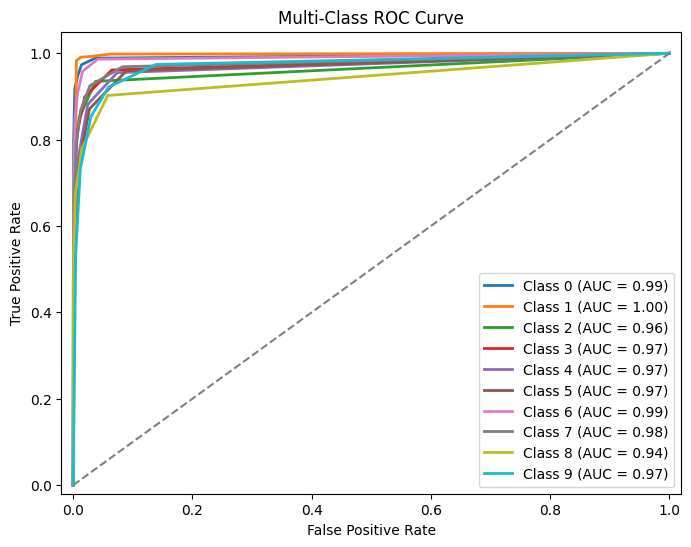

In [9]:
# ROC Curve
n_classes = len(np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix Visualization**

The code computes a confusion matrix to compare actual vs. predicted labels, then visualizes it using a heatmap. This helps analyze the model's performance by showing correct and misclassified instances for each class.

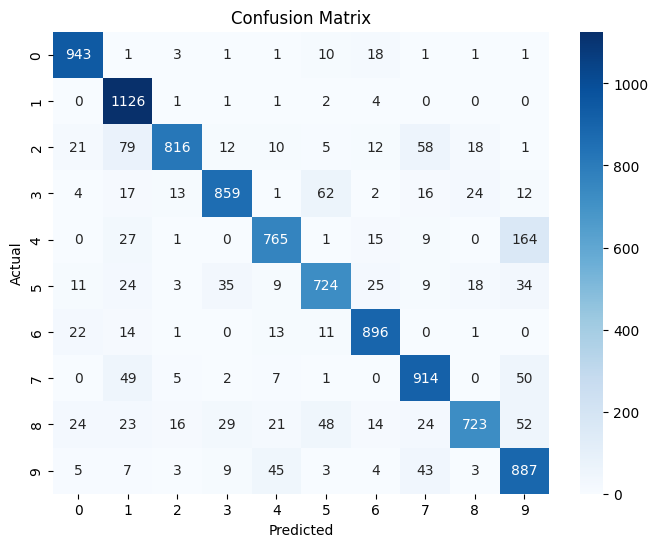

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()